In [4]:
import time
import torch
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from sjlt import SJLTProjection

# First, check if CUDA is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda:0


In [12]:
# Set the hyperparameters
torch.manual_seed(42)
data_type = torch.bfloat16 # torch.float64, torch.float32, torch.float16, torch.bfloat16
batch_size = 128
original_dim = 131072
projection_dims = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768]
sparsity_levels = [0, 0.3, 0.6, 0.9]

In [ ]:
def compute_pairwise_distance_metrics(batch_vec, batch_vec_p):
    """
    Computes relative error, RMSE, and stress between pairwise distances of
    original and projected datasets.

    Arguments:
    batch_vec (Tensor) : original data (batch of vectors)
    batch_vec_p (Tensor) : projected data (batch of projected vectors)

    Returns:
    relative_error (float) : average relative error between original and projected pairwise distances
    """
    # Convert to float32 to avoid numerical overflow with float16
    # float16 has max value ~65504, and pairwise distances can easily overflow
    original_dtype = batch_vec.dtype
    if batch_vec.dtype in (torch.float16, torch.bfloat16):
        batch_vec = batch_vec.float()
        batch_vec_p = batch_vec_p.float()

    # Compute pairwise distances
    original_distances = torch.cdist(batch_vec, batch_vec, p=2)
    projected_distances = torch.cdist(batch_vec_p, batch_vec_p, p=2)

    # Avoid division by zero for any zero distances in the original data
    mask = original_distances > 1e-8  # Mask to filter out zero distances

    # Compute Relative Error
    relative_errors = torch.abs((original_distances[mask] - projected_distances[mask]) / original_distances[mask])
    average_relative_error = torch.mean(relative_errors).item()
    return average_relative_error

In [14]:
def benchmark(batch_size, original_dim,  projection_dims, sparsity_levels, device, include_gaussian=True):
    """
    Compare Gaussian, vanilla SJLT, and CUDA SJLT projection methods across different sparsity levels.

    Arguments:
    projection_dims (list) : List of projection dimensions to test
    sparsity_levels (list) : List of sparsity levels to test (0.0 to 1.0)
    device (str) : Device to use for computation ("cuda" or "cpu")
    include_gaussian (bool) : Whether to include Gaussian projection in the comparison (set to False to avoid OOM errors for large dimensions). default=True

    Returns:
    results (dict) : Dictionary containing all results
    """

    # Results dictionaries
    results = {
        "sjlt": {
            "times": {sparsity: [] for sparsity in sparsity_levels},
            "relative_errors": {sparsity: [] for sparsity in sparsity_levels}
        },
        "sjlt_cuda": {
            "times": {sparsity: [] for sparsity in sparsity_levels},
            "relative_errors": {sparsity: [] for sparsity in sparsity_levels}
        }
    }

    # Add Gaussian results dict only if we're including it
    if include_gaussian:
        results["gaussian"] = {
            "times": {sparsity: [] for sparsity in sparsity_levels},
            "relative_errors": {sparsity: [] for sparsity in sparsity_levels}
        }

    # Create a batch of vectors
    batch_vec = torch.randn(batch_size, original_dim, device=device, dtype=data_type)

    # Backup original vectors
    batch_vec_clone = batch_vec.clone()

    # SJLT parameters
    c = 1

    for proj_dim in projection_dims:
        print(f"Processing projection dimension: {proj_dim}")

        # For Gaussian projection - only create if needed
        if include_gaussian:
            try:
                gaussian_matrix = torch.randn(proj_dim, original_dim, device=device, dtype=data_type) / (proj_dim ** 0.5)
            except RuntimeError as e:
                if "out of memory" in str(e).lower():
                    print(f"  WARNING: OOM error when creating Gaussian matrix for dim={proj_dim}.")
                    print(f"  Disabling Gaussian comparison for this and larger dimensions.")
                    include_gaussian = False  # Disable for future iterations
                else:
                    raise  # Re-raise if it's not an OOM error

        # For SJLT projection
        rand_indices = torch.randint(proj_dim, (original_dim, c), device=device, dtype=torch.int32)
        rand_signs = torch.randint(0, 2, (original_dim, c), device=device, dtype=torch.int32) * 2 - 1

        # Initialize CUDA SJLT module
        sjlt_cuda_module = SJLTProjection(original_dim, proj_dim, c, device=device)
        # Make sure it uses the same random indices and signs for fair comparison
        sjlt_cuda_module.rand_indices.copy_(rand_indices)
        sjlt_cuda_module.rand_signs.copy_((rand_signs.to(torch.int8)))

        for sparsity in sparsity_levels:
            print(f"  Sparsity level: {sparsity}")
            batch_vec = batch_vec_clone.clone()

            # Sparsify the vectors by randomly setting a fraction (sparsity) of elements to zero
            if sparsity > 0:
                num_elements_to_drop = int(sparsity * original_dim)
                for i in range(batch_size):
                    indices_to_drop = torch.randperm(original_dim, device=device)[:num_elements_to_drop]
                    batch_vec[i, indices_to_drop] = 0

            # --- Gaussian Projection ---
            if include_gaussian:
                try:
                    # Cold Start once to avoid overhead
                    batch_vec_gaussian = batch_vec @ gaussian_matrix.T

                    # Time the Gaussian projection
                    torch.cuda.synchronize(device)
                    start_time = time.time()

                    # Perform Gaussian projection
                    batch_vec_gaussian = batch_vec @ gaussian_matrix.T

                    torch.cuda.synchronize(device)
                    gaussian_time = time.time() - start_time

                    # Calculate relative error for Gaussian
                    gaussian_error = compute_pairwise_distance_metrics(batch_vec, batch_vec_gaussian)

                    # Store results
                    results["gaussian"]["times"][sparsity].append(gaussian_time)
                    results["gaussian"]["relative_errors"][sparsity].append(gaussian_error)

                except RuntimeError as e:
                    if "out of memory" in str(e).lower():
                        print(f"  WARNING: OOM error during Gaussian projection for dim={proj_dim}, sparsity={sparsity}.")
                        print(f"  Disabling Gaussian comparison for this and larger dimensions.")
                        include_gaussian = False  # Disable for future iterations

                        # Add None values to maintain consistency in results
                        if "gaussian" in results:
                            results["gaussian"]["times"][sparsity].append(None)
                            results["gaussian"]["relative_errors"][sparsity].append(None)
                    else:
                        raise  # Re-raise if it's not an OOM error

            # --- SJLT Projection (PyTorch implementation) ---

            # Cold Start once to avoid overhead
            batch_size, _ = batch_vec.size()

            # Get indices of elements above 0 in a single pass
            batch_idx, input_idx = torch.nonzero(torch.abs(batch_vec) > 0, as_tuple=True)
            values = batch_vec[batch_idx, input_idx]

            scaled_vals = values.repeat_interleave(c) * rand_signs[input_idx].flatten()
            final_indices = batch_idx.repeat_interleave(c) * proj_dim + rand_indices[input_idx].flatten()

            # Initialize and fill output tensor
            batch_vec_sjlt = torch.zeros(batch_size, proj_dim, device=device, dtype=data_type)
            batch_vec_sjlt.view(-1).index_add_(0, final_indices, scaled_vals)

            # Sum and normalize
            batch_vec_sjlt = batch_vec_sjlt.view(batch_size, proj_dim) / (c ** 0.5)

            # Time the SJLT projection
            torch.cuda.synchronize(device)
            start_time = time.time()

            # Perform SJLT projection
            batch_size, _ = batch_vec.size()

            # Get indices of elements above 0 in a single pass
            batch_idx, input_idx = torch.nonzero(torch.abs(batch_vec) > 0, as_tuple=True)
            values = batch_vec[batch_idx, input_idx]

            scaled_vals = values.repeat_interleave(c) * rand_signs[input_idx].flatten()
            final_indices = batch_idx.repeat_interleave(c) * proj_dim + rand_indices[input_idx].flatten()

            # Initialize and fill output tensor
            batch_vec_sjlt = torch.zeros(batch_size, proj_dim, device=device, dtype=data_type)
            batch_vec_sjlt.view(-1).index_add_(0, final_indices, scaled_vals)

            # Sum and normalize
            batch_vec_sjlt = batch_vec_sjlt.view(batch_size, proj_dim) / (c ** 0.5)

            torch.cuda.synchronize(device)
            sjlt_time = time.time() - start_time

            # Calculate relative error for SJLT
            sjlt_error = compute_pairwise_distance_metrics(batch_vec, batch_vec_sjlt)

            # Store results
            results["sjlt"]["times"][sparsity].append(sjlt_time)
            results["sjlt"]["relative_errors"][sparsity].append(sjlt_error)

            # --- SJLT CUDA Projection ---

            # Cold Start once to avoid overhead
            with torch.no_grad():
                batch_vec_sjlt_cuda = sjlt_cuda_module(batch_vec)

            # Time the CUDA SJLT projection
            torch.cuda.synchronize(device)
            start_time = time.time()

            # Perform CUDA SJLT projection
            with torch.no_grad():
                batch_vec_sjlt_cuda = sjlt_cuda_module(batch_vec)

            torch.cuda.synchronize(device)
            sjlt_cuda_time = time.time() - start_time

            # Calculate relative error for CUDA SJLT
            sjlt_cuda_error = compute_pairwise_distance_metrics(batch_vec, batch_vec_sjlt_cuda)

            # Store results
            results["sjlt_cuda"]["times"][sparsity].append(sjlt_cuda_time)
            results["sjlt_cuda"]["relative_errors"][sparsity].append(sjlt_cuda_error)

            # Verify that both SJLT implementations give similar results
            diff = torch.abs(batch_vec_sjlt - batch_vec_sjlt_cuda).max().item()
            print(f"    Max difference between PyTorch and CUDA SJLT: {diff:.6f}")

    return results

In [15]:
results = benchmark(batch_size, original_dim, projection_dims, sparsity_levels, device, include_gaussian=True)

Processing projection dimension: 32
  Sparsity level: 0
    Max difference between PyTorch and CUDA SJLT: 36.500000
  Sparsity level: 0.3
    Max difference between PyTorch and CUDA SJLT: 22.000000
  Sparsity level: 0.6
    Max difference between PyTorch and CUDA SJLT: 13.750000
  Sparsity level: 0.9
    Max difference between PyTorch and CUDA SJLT: 3.750000
Processing projection dimension: 64
  Sparsity level: 0
    Max difference between PyTorch and CUDA SJLT: 19.000000
  Sparsity level: 0.3
    Max difference between PyTorch and CUDA SJLT: 11.500000
  Sparsity level: 0.6
    Max difference between PyTorch and CUDA SJLT: 7.750000
  Sparsity level: 0.9
    Max difference between PyTorch and CUDA SJLT: 1.625000
Processing projection dimension: 128
  Sparsity level: 0
    Max difference between PyTorch and CUDA SJLT: 12.000000
  Sparsity level: 0.3
    Max difference between PyTorch and CUDA SJLT: 6.500000
  Sparsity level: 0.6
    Max difference between PyTorch and CUDA SJLT: 3.750000


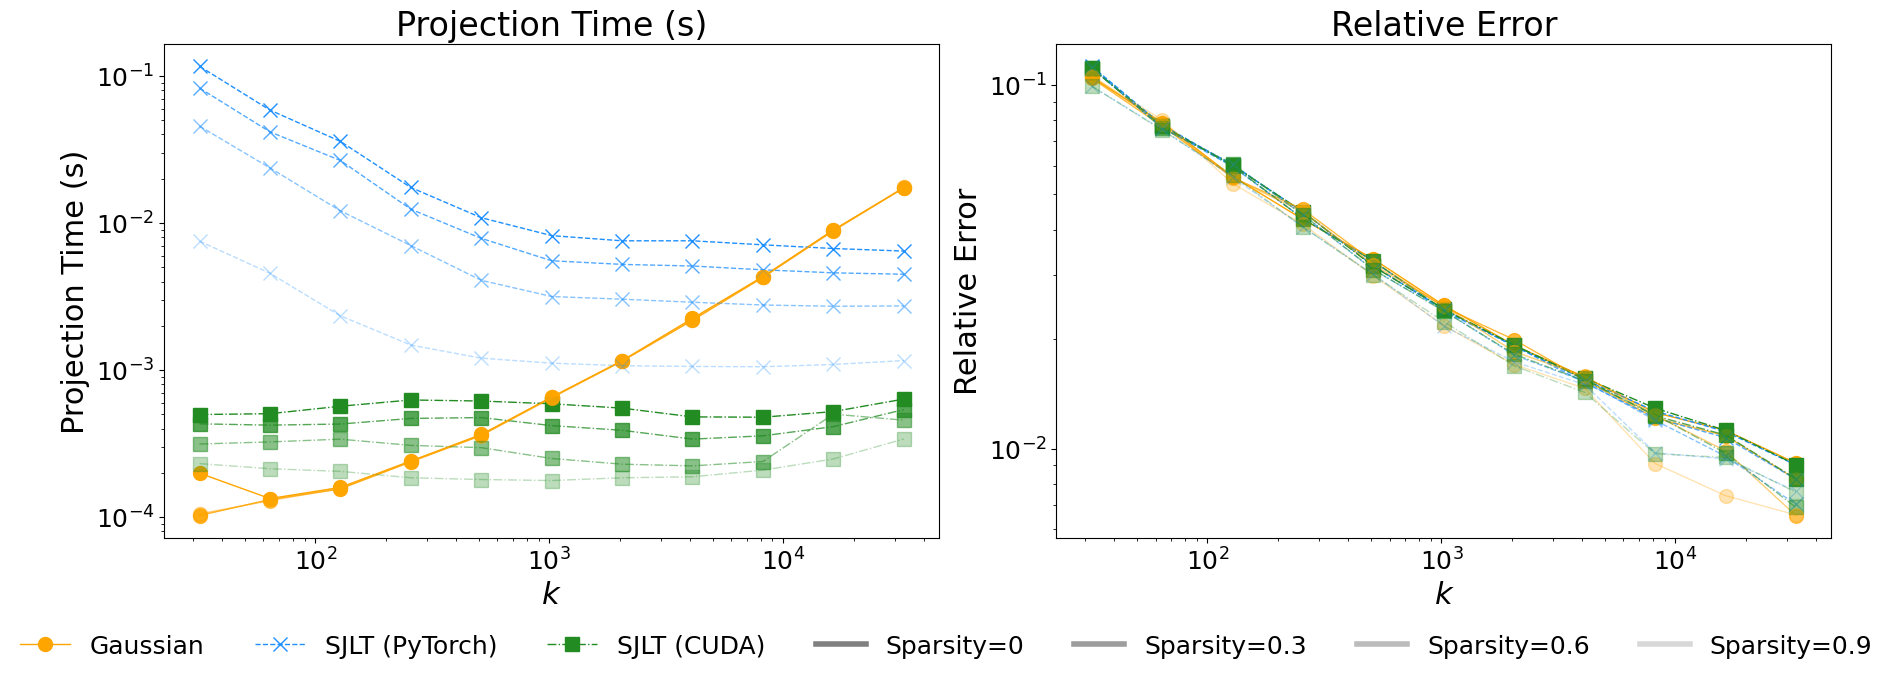

In [16]:
def plot_benchmark(results, projection_dims, sparsity_levels, log_scale=True):
    colors = {
        "SJLT": 'dodgerblue',
        "Gaussian": 'orange',
        "SJLT_CUDA": 'forestgreen'
    }

    linestyles = {
        "SJLT": '--',
        "Gaussian": '-',
        "SJLT_CUDA": '-.'
    }

    markers = {
        "SJLT": 'x',
        "Gaussian": 'o',
        "SJLT_CUDA": 's'
    }

    marker_size = 10

    min_alpha = 0.3
    max_alpha = 1.0
    sorted_sparsity = sorted(sparsity_levels)
    alphas = {
        s: max_alpha - i / max(1, len(sparsity_levels)-1) * (max_alpha - min_alpha)
        for i, s in enumerate(sorted_sparsity)
    }

    # Side-by-side subplots
    fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharex=True)

    include_gaussian = "gaussian" in results

    titles = ["Projection Time (s)", "Relative Error"]
    ylabels = ["Projection Time (s)", "Relative Error"]

    metrics = ["times", "relative_errors"]
    for i, metric in enumerate(metrics):
        ax = axes[i]
        for sparsity in sparsity_levels:
            alpha = alphas[sparsity]

            if include_gaussian:
                valid_dims = []
                valid_vals = []
                for j, val in enumerate(results["gaussian"][metric][sparsity]):
                    if val is not None and j < len(projection_dims):
                        valid_dims.append(projection_dims[j])
                        valid_vals.append(val)

                if valid_dims:
                    ax.plot(valid_dims, valid_vals,
                            marker=markers["Gaussian"], linestyle=linestyles["Gaussian"],
                            linewidth=1, markersize=marker_size,
                            color=colors["Gaussian"], alpha=alpha)

            ax.plot(projection_dims, results["sjlt"][metric][sparsity],
                    marker=markers["SJLT"], linestyle=linestyles["SJLT"],
                    linewidth=1, markersize=marker_size,
                    color=colors["SJLT"], alpha=alpha)

            ax.plot(projection_dims, results["sjlt_cuda"][metric][sparsity],
                    marker=markers["SJLT_CUDA"], linestyle=linestyles["SJLT_CUDA"],
                    linewidth=1, markersize=marker_size,
                    color=colors["SJLT_CUDA"], alpha=alpha)

        ax.set_title(titles[i], fontsize=24)
        ax.set_ylabel(ylabels[i], fontsize=22)
        ax.tick_params(axis='both', which='major', labelsize=18)
        if log_scale:
            ax.set_xscale('log')
            ax.set_yscale('log')

    axes[0].set_xlabel("$k$", fontsize=22)
    axes[1].set_xlabel("$k$", fontsize=22)

    # Legends
    method_handles = [
        Line2D([0], [0], linestyle=linestyles[m], color=colors[m],
               marker=markers[m], linewidth=1, markersize=marker_size, label=label)
        for m, label in zip(["Gaussian", "SJLT", "SJLT_CUDA"],
                            ["Gaussian", "SJLT (PyTorch)", "SJLT (CUDA)"]) if m in colors
    ]

    sparsity_handles = [
        Line2D([0], [0], linestyle='-', color='gray', alpha=alphas[s],
               linewidth=4, label=f'Sparsity={s}')
        for s in sparsity_levels
    ]

    all_handles = method_handles + sparsity_handles
    fig.legend(handles=all_handles, loc='lower center', ncol=len(all_handles),
               bbox_to_anchor=(0.5, 0.02), fontsize=18, frameon=False)

    plt.tight_layout(rect=[0, 0.1, 1, 1])
    plt.show()

plot_benchmark(results, projection_dims, sparsity_levels)